# 一. 重返泰坦尼克号

本次数据分析的对象是泰坦尼克号数据，包括泰坦尼克号上2224名乘客和船员中891名的人口学数据和乘客基本信息，由Kaggle网站提供。下表中展示了前5条数据的基本情况：

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

In [74]:
# calculate_ratio calcluates ratios for scales and vectors.
def calculate_ratio(frac, total):
    return frac / total

# format_percent formats a decimal fraction into percentage string.
def format_percent(frac):
    return str(round(frac, 4) * 100) + '%'

In [75]:
# take a look at data
titanic_df = pd.read_csv('titanic-data.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


每个乘客包含12项基本信息：

1. PassengerId：乘客唯一ID
2. Survived：是否生还，0表示遇难，1表示生还
3. Pclass：客舱等级，1表示头等舱，2表示二等舱，3表示下等舱
4. Name：乘客姓名
5. Sex：性别，男（male）或女（female）
6. Age：年龄
7. SibSp：同在船上的兄弟姐妹/配偶数量
8. Parch：同在船上的双亲/子女数量
9. Ticket：票号
10. Fare：船票票价
11. Cabin：客舱号
12. Embarked：登船港口，C = Cherbourg, Q = Queenstown, S = Southampton

从表格中展示的基本情况可以看出，有一部分乘客的客舱号数据已经遗失（NaN）。另外根据Kaggle上的说明，乘客的年龄为浮点数，小于1岁的乘客年龄为分数，如果不知道确切年龄，那么乘客的年龄格式为xx.5。sibsp数据忽略了未婚夫/未婚妻关系，parch数据包括了继子/继女关系，一些儿童乘客是跟保姆一起坐船的，对他们而言parch=0。

# 二. 感兴趣的问题

对于泰坦尼克号数据，我所感兴趣的问题是：

1. 乘客汇总统计信息和总体生还情况¶
2. 乘客的年龄分布大致情况，最大年龄和最小年龄的生还情况是怎样的？
3. 不同年龄段乘客的生还率是怎样的？
4. 乘客在船票上的花费是怎样的？
5. 不同客舱等级乘客的生还率和平均船票花费分别是怎样的？
6. 不同性别乘客的生还率和平均船票花费分别是怎样的？
7. 带着兄弟姐妹/配偶一同登船的乘客，他们的生还率如何？其中的男性乘客呢？女性乘客呢？
8. 带着双亲/子女一同登船的乘客，他们的生还率如何？其中的男性乘客呢？女性乘客呢？
9. 0-16岁儿童乘客的生还情况如何？其中有多少是没有跟着父母一起登船的？他们的生还情况如何？

# 三. 对数据进行整理

In [76]:
# check whether number of rows and unique number of passengers match
num_of_rows = len(titanic_df['PassengerId'])
num_of_uniq = len(titanic_df['PassengerId'].unique())
print('# of rows: {}; # of unique passengers: {}\n'.format(num_of_rows, num_of_uniq))

# check if there exists missing data.
print('investigate the missing data of each columns:')
missing = titanic_df.isnull().sum()
ratio = calculate_ratio(titanic_df.isnull().sum(), float(len(titanic_df)))
round_ratio = ratio.apply(lambda x: str(round(x, 4) * 100) + '%')
print(pd.concat([missing.rename('missing'), round_ratio.rename('percentage(%)')], axis='columns'))

# are Pclass, Sex and Embarked data avaiable?
print('\ninvestigating Pclass')
print(titanic_df.groupby('Pclass').groups.keys())

print('\ninvestigating Sex')
print(titanic_df.groupby('Sex').groups.keys())

print('\ninvestigating Embarked')
print(titanic_df.groupby('Embarked').groups.keys())

# of rows: 891; # of unique passengers: 891

investigate the missing data of each columns:
             missing percentage(%)
PassengerId        0          0.0%
Survived           0          0.0%
Pclass             0          0.0%
Name               0          0.0%
Sex                0          0.0%
Age              177        19.87%
SibSp              0          0.0%
Parch              0          0.0%
Ticket             0          0.0%
Fare               0          0.0%
Cabin            687         77.1%
Embarked           2         0.22%

investigating Pclass
[1, 2, 3]

investigating Sex
['male', 'female']

investigating Embarked
['Q', 'C', 'S']


从以上对数据的初步调查可以看出，数据集的行数与乘客的数量相等，也就是说**不存在重复的数据**。然而年龄、客舱和登船港口数据存在缺失。有177名乘客的年龄数据缺失，占比19.87%，那么**在进行针对年龄的数据分析时必须把这部分数据筛除，否则势必影响结论的可靠性**；有687项数据缺失了客舱信息，占比77.1%，是数据缺失的重灾区，好在这对后面要进行的数据分析不存在影响：我们只需要知道客舱的等级就好，不需要知道具体客舱号，客舱等级数据不存在缺失。登陆港口只有两项数据是缺失的，占比不大，因此对结论的影响较小。最后，检查了一下客舱等级，性别和登陆港口数据，因为这些数据是有限取值范围的枚举值，检查下有没有错误数据，**结论是没有**。

In [77]:
# filter out NaN 'Age' data, drop 'Cabin' too.
titanic_df_age = titanic_df[pd.notnull(titanic_df['Age'])].drop('Cabin', axis=1)
# filter out NaN 'Embarked' data, drop 'Cabin' too.
titanic_df_embark = titanic_df[pd.notnull(titanic_df['Embarked'])].drop('Cabin', axis=1)
# check the filtered data.
print('valid age {}, valid embark {}'.format(len(titanic_df_age), len(titanic_df_embark)))
display(titanic_df_age.head())
display(titanic_df_embark.head())

valid age 714, valid embark 889


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


为方便后面的分析工作，我们对数据进行了清洗。对于后面要进行的有关乘客年龄的数据分析，我们将缺失数据滤除，对登陆港口也做同样处理，由于只需要知道客舱等级而不再需要客舱号，因此顺便将客舱号这列删除。最后打印了一下清洗后的数据进行观察，跟预期的一致，没有问题。

# 四. 数据分析

## 1. 乘客汇总统计信息和总体生还情况

In [78]:
display(titanic_df.describe())
sum_of_survived = titanic_df['Survived'].sum()
survived_percent = format_percent(calculate_ratio(sum_of_survived, float(len(titanic_df))))
print('number of passengers survived {} about {}'.format(sum_of_survived, survived_percent))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


number of passengers survived 342 about 38.38%


891名乘客平均年龄约29.70周岁，标准差为14.53，表明年龄分布较为分散，最大年龄乘客80岁，最小的不足1岁；有乘客最多带了8位家属（兄弟姐妹/配偶）登船，还有的乘客最多带了6位直系血亲（父母/子女）登船；这些乘客购买船票平均花费了约32.20货币单位，标准差49.69，表明不同乘客的船票开销差异较大。891人中仅342人生还，总体生还率约38.38%。

## 2. 乘客的年龄分布大致情况，最大年龄和最小年龄的生还情况是怎样的？

Age
(0, 10]      64
(10, 20]    115
(20, 30]    230
(30, 40]    155
(40, 50]     86
(50, 60]     42
(60, 70]     17
(70, 80]      5
Name: PassengerId, dtype: int64

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,S


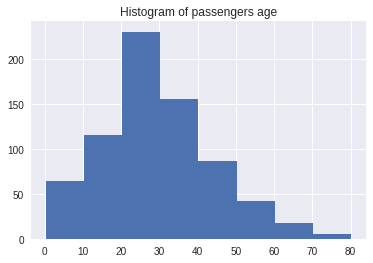

In [80]:
# get categories by Age ranges.
cat_age = pd.cut(titanic_df_age["Age"], np.arange(0, 90, 10))
display(titanic_df_age.groupby(cat_age).count()['PassengerId'])

# ages are between 0 and 80.
plt.title('Histogram of passengers age')
titanic_df_age['Age'].hist(bins=8)

display(titanic_df_age[titanic_df_age.Age == 80])
display(titanic_df_age[titanic_df_age.Age < 1])

由于乘客最大年龄为80岁，最小不足1岁，所以从乘客年龄范围统计数据和直方图的角度观察数据，发现20岁以上30岁以下的乘客数量最多，达230人，其次是30岁以上40岁以下，有155人。然后我们检查了最大年龄为80岁的乘客和所有不足1岁乘客的生还情况，发现他们都生还了，真是幸运！

## 3. 不同年龄段乘客的生还情况是怎样的？

passengers with available age: total 714 survived 40.62%


Age
(0, 10]      5.32%
(10, 20]     6.16%
(20, 30]    11.76%
(30, 40]     9.66%
(40, 50]     4.62%
(50, 60]     2.38%
(60, 70]     0.56%
(70, 80]     0.14%
Name: Survived, dtype: object

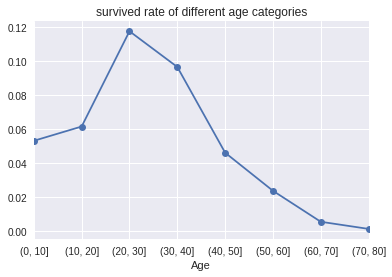

In [83]:
# data with available 'Age'
sum_of_survived_age = titanic_df_age['Survived'].sum()
total_passengers_age = len(titanic_df_age)
survived_percent_age = format_percent(calculate_ratio(sum_of_survived_age, float(total_passengers_age)))
print('passengers with available age: total {} survived {}'.format(total_passengers, survived_percent_age))

# data group by age ranges.
survived_sum_grouped = titanic_df_age.groupby(cat_age)['Survived'].sum()
survived_ratio_grouped = calculate_ratio(survived_sum_grouped, float(total_passengers_age))
ax1 = survived_ratio_grouped.plot(style='o-')
ax1.set_title('survived rate of different age categories')

survived_ratio_grouped.apply(lambda x: format_percent(x))

以上是对具有有效年龄数据的乘客进行的统计分析。可以看到生还的乘客占总人数的比例约为40.62%。因为最大年龄为80岁，因此这里我们对年龄进行了从0到80岁的分段分析，发现20岁以上30岁以下的乘客生还率最高，其次是30岁以上40岁以下的。小于20岁的年龄越小生还率越低；大于40岁的年龄越大生还率越低。对此我提出这样一种结论：年龄能够影响生还率。20岁-40岁正是身体和心智成熟的巅峰时期，在面临巨大灾难时生还率较高。

## 4. 乘客在船票上的花费是怎样的？

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


num of passengers who spent fare <= 100: 838


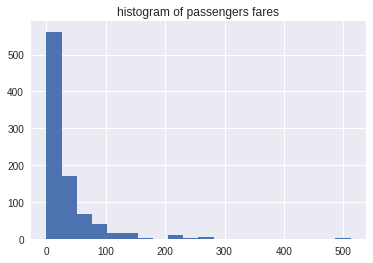

In [84]:
display(titanic_df[titanic_df['Fare'] == 0.0])

ax = titanic_df['Fare'].hist(bins=20)
ax.set_title('histogram of passengers fares')

cat_fare = pd.cut(titanic_df['Fare'], np.arange(0, 550, 20))
print('num of passengers who spent fare <= 100: {}'.format(titanic_df[titanic_df['Fare'] <= 100.0]['PassengerId'].count()))

在这891名乘客中，绝大多数乘客（838名）船票花费不足100个货币单位。由于发现还有没花钱免费坐船的乘客，于是对这部分乘客比较好奇，调查了所有没有花钱买船票的乘客来观察他们，发现他们有几个共同点：1.没有带兄弟姐妹/配偶；2.没有带父母/子女；3.都是男性；4.绝大部分都已遇难，只有1人生还；5.登船地点都是Southampton。查了泰坦尼克号的维基百科，这艘游轮正是**1912年4月10日从英国南安普顿**出发的，因此这些免费乘船的乘客应该都是泰坦尼克号上的船员。

## 5. 不同客舱等级乘客的生还率和平均船票花费分别是怎样的？

num of passengers of different pclass: Pclass
1    216
2    184
3    491
Name: PassengerId, dtype: int64


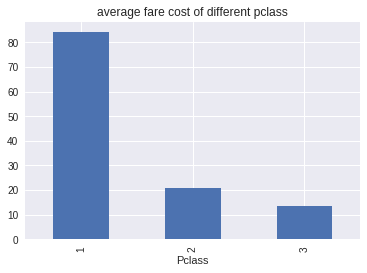

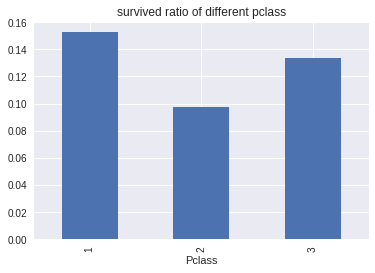

In [85]:
passengers_grouped_pclass = titanic_df.groupby('Pclass')
print('num of passengers of different pclass: {}'.format(passengers_grouped_pclass['PassengerId'].count()))

# fare cost group by PClass
fare_sum_pclass = passengers_grouped_pclass['Fare'].sum()
fare_count_pclass = passengers_grouped_pclass['PassengerId'].count()
avg_fare_cost_pclass = calculate_ratio(fare_sum_pclass, fare_count_pclass)
ax2 = avg_fare_cost_pclass.plot(kind='bar')
ax2.set_title('average fare cost of different pclass')

plt.figure()

survived_sum_pclass = passengers_grouped_pclass['Survived'].sum()
survived_ratio_pclass = calculate_ratio(survived_sum_pclass, float(len(titanic_df)))
ax1 = survived_ratio_pclass.plot(kind='bar')
ax1.set_title('survived ratio of different pclass')


头等舱乘客人均花费远高于二等舱和三等舱，这是意料之中的事情。然而从生还率上看，头等舱和三等舱乘客生还率较高，反而二等舱乘客生还率是最低的。因此并不能说明舱位等级越高生还率就越高，一定还有别的什么影响因素。

## 6. 不同性别乘客的生还率和平均船票花费分别是怎样的？

num of passengers of different gender: Sex
female    314
male      577
Name: PassengerId, dtype: int64


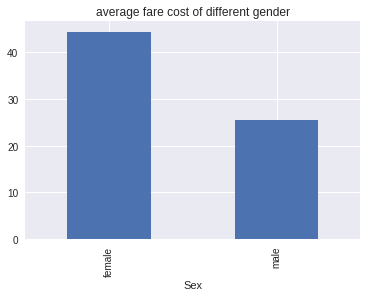

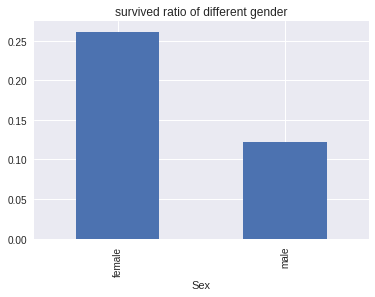

In [87]:
passengers_grouped_gender = titanic_df.groupby('Sex')
print('num of passengers of different gender: {}'.format(passengers_grouped_gender['PassengerId'].count()))

# fare cost group by gender
gender_grouped_sum = passengers_grouped_gender['Fare'].sum()
gender_grouped_count = passengers_grouped_gender['PassengerId'].count()
avg_fare_cost_gender = calculate_ratio(gender_grouped_sum, gender_grouped_count)
ax2 = avg_fare_cost_gender.plot(kind='bar')
ax2.set_title('average fare cost of different gender')

plt.figure()

# survival group by gender
gender_grouped_survived = passengers_grouped_gender['Survived'].sum()
survived_ratio_gender = calculate_ratio(gender_grouped_survived, float(len(titanic_df)))
ax1 = survived_ratio_gender.plot(kind='bar')
ax1.set_title('survived ratio of different gender')

891名乘客中男性乘客有577人，女性乘客有314人。然而女性乘客的平均船票花费却远高于男性乘客，与此同时女性乘客的生还率也比男性乘客要高出很多。在救生船有限的情况下，男人们充分体现了自己的绅士风度，把生的机会留给了女人和小孩。

## 7. 带着兄弟姐妹/配偶一同登船的乘客，他们的生还率如何？其中的男性乘客呢？女性乘客呢？

survived rate of passengers with siblings/spouse: 14.81%


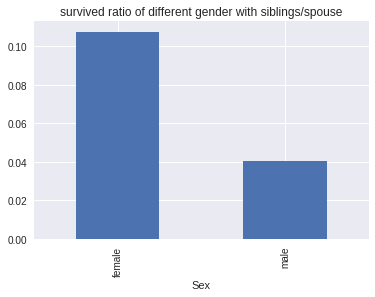

In [92]:
# passengers with siblings or spouse or both.
titanic_df_sibsp = titanic_df[titanic_df['SibSp'] > 0]
survived_ratio_sibsp = calculate_ratio(titanic_df_sibsp['Survived'].sum(), float(len(titanic_df)))
print('survived rate of passengers with siblings/spouse: {}'.format(format_percent(survived_ratio_sibsp)))

passengers_sibsp_gender = titanic_df_sibsp.groupby('Sex')
survived_ratio_sibsp_gender = passengers_sibsp_gender['Survived'].sum() / len(titanic_df)
survived_ratio_sibsp_gender = calculate_ratio(passengers_sibsp_gender['Survived'].sum(), float(len(titanic_df)))
ax1 = survived_ratio_sibsp_gender.plot(kind='bar')
ax1.set_title('survived ratio of different gender with siblings/spouse')

带着兄弟姐妹/配偶一同登船的乘客，其总体生还率为14.81%，且其中女性的生还率还是要比男性高很多。

## 8. 带着双亲/子女一同登船的乘客，他们的生还率如何？其中的男性乘客呢？女性乘客呢？

survived rate of passengers with parents/children: 12.23%


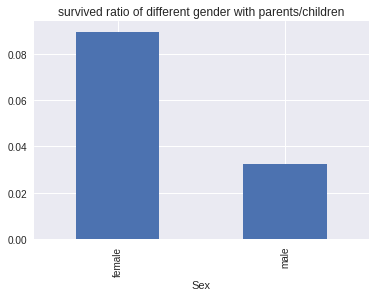

In [93]:
# passengers with parents or children or both.
titanic_df_parch = titanic_df[titanic_df['Parch'] > 0]
survived_ratio_parch = calculate_ratio(titanic_df_parch['Survived'].sum(), float(len(titanic_df)))
print('survived rate of passengers with parents/children: {}'.format(format_percent(survived_ratio_parch)))

passengers_parch_gender = titanic_df_parch.groupby('Sex')
survived_ratio_parch_gender = passengers_parch_gender['Survived'].sum() / len(titanic_df)
survived_ratio_parch_gender = calculate_ratio(passengers_parch_gender['Survived'].sum(), float(len(titanic_df)))
ax1 = survived_ratio_parch_gender.plot(kind='bar')
ax1.set_title('survived ratio of different gender with parents/children')

带着父母/子女一同乘船的乘客，总的生还率为12.23%，这比带着兄弟姐妹/配偶的乘客生还率要低一些。其中女性的生还率又比男性要高。兄弟姐妹或者配偶是年纪相差不大的同龄人，而父母年迈，子女幼小，照顾的难度自然比较大，这些乘客的生还率就要低一些。

## 9. 0-16岁儿童乘客的生还情况如何？其中有多少是没有跟着父母一起登船的？他们的生还情况如何？

In [94]:
# passengers whose age below 17.
kid_passengers = titanic_df_age[titanic_df_age['Age'] < 17]
kids_survived = kid_passengers[kid_passengers['Survived'] == 1]
survive_percentage = format_percent(calculate_ratio(len(kids_survived), float(len(titanic_df_age))))
print('num of kids: {}, num of kids survived: {}, survived about {}% compared to all'.
      format(len(kid_passengers), len(kids_survived), survive_percentage))

# kids with no parents aboard.
kids_no_parch = kid_passengers[kid_passengers['Parch'] == 0]
kids_no_parch_survived = kids_no_parch[kids_no_parch['Survived'] == 1]
print('num of kids with no parents: {}, survived: {}'.format(len(kids_no_parch), len(kids_no_parch_survived)))

num of kids: 100, num of kids survived: 55, survived about 7.7%% compared to all
num of kids with no parents: 22, survived: 12


共有100名0-16岁的儿童乘客，其中有55人幸免于难。生还率约7.7%。其中22人是没有和父母一同乘船的，这22人中有12个人幸免于难。

## 10. 独自一人登船的乘客生还情况如何？

In [95]:
# passengers alone aboard.
passengers_alone = titanic_df[titanic_df['SibSp'] == 0]
passengers_alone = passengers_alone[passengers_alone['Parch'] == 0]
survived_alone = passengers_alone[passengers_alone['Survived'] == 1]
survived_rate_alone = format_percent(calculate_ratio(len(survived_alone), float(len(titanic_df))))
print('num of passengers alone: {}, survived: {}, about {} compared to total'.format(len(passengers_alone), len(survived_alone), survived_rate_alone))

num of passengers alone: 537, survived: 163, about 18.29% compared to total


独自一人登船的乘客有537人，其中163人幸免于难，生还率约18.29%，这个比例要高于带着兄弟姐妹/配偶以及带着父母/子女的乘客，毕竟一人吃饱全家不饿，无牵无挂的逃难更快，没有什么好顾虑的。

# 五. 得出结论

从上面的分析中我们可以得出一些初步的结论。首先**年龄是影响生还率的因素之一**，那些20岁-40岁的乘客，有了成熟的心智和较好的身体素质，是比较容易抵抗灾难的侵袭的，生还率较高；其次**数据并不能说明客舱等级越高就越容易生还**，二等舱的乘客反而没有头等舱和三等舱乘客生还率高，从船票开销上看，**女人们还是比男人们更愿意花钱**；然后，**性别也是影响生还率的因素之一**，女性乘客比男性乘客生还率高很多，因为男人们更有绅士风度，把有限的救生船名额先让给了女人和小孩，这一点还是非常值得敬佩的；**拖家带口的乘客生还率就不如独自一人乘船的乘客**，可以合理推测，独自一人逃难要更容易一些，毕竟无牵无挂，而**带着兄弟姐妹/配偶的乘客又比带着父母/子女的乘客生还率要高**，毕竟跟同龄人一起躲避灾难，还是比和自己年长或年幼的人一起躲避灾难要轻松一些；最后，**16周岁以下的儿童乘客，还是有将近一半的人幸存下来，但是总体生还率还是偏低**。

以上对数据的调查和探索得出的结论都只是暂时的。首先样本数据只有891条，如果有更多的数据，也许能得出不太一样或者截然相反的结论。其次，有177位乘客的年龄数据是缺失的，这势必会对上文基于年龄的各项分析产生影响，这是数据固有的局限性。如果严肃的对待数据分析，那么以上结论必须经过统计检验后才能对统计显著性下定论。